In [55]:
# import basic libraries 
import pandas as pd
import seaborn as sb
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk import download
import itertools
import collections
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import re
import string

# read csv
df = pd.read_csv('../csv/data_clean.csv')
df_copy = df.copy()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilmac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lilmac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Sentiment Score

In [56]:
# save a copy
df_sent = df.copy()

In [57]:
def clean_links(df):
#replace URL of a text
    df_sent['text'] = df_sent['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

clean_links(df_sent)
df_sent['text']

<ipython-input-57-2a3e1b840ed1>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sent['text'] = df_sent['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


0                     Hang told me to add it in education
1       What improved my score was adding metrics of a...
2       I feel like a slave to this dumb Resume Worded...
3       Francisco, we have to remove the fancy/beautif...
4                                                 Ah, ok!
                              ...                        
4935                                Just saw this. Thanks
4936    I'll have a think. Need to develop a strategy ...
4937            heeeellppp…anyone? <@U01RSRE0N3D>? :eyes:
4938        I will have a look after the presentation :v:
4939    I quite like the Kaggle explanations. Been rea...
Name: text, Length: 4940, dtype: object

In [58]:
# change column dtype into string
df_sent['text'] = df_sent['text'].astype(str)

In [59]:
# change column to list
text_list = df_sent['text'].tolist()

In [60]:
# load VADER
sid = SentimentIntensityAnalyzer()
# add VADER metrics to dataframe

df_sent['scores'] = df_sent['text'].apply(lambda text: sid.polarity_scores(text))

df_sent['compound']  = df_sent['scores'].apply(lambda score_dict: score_dict['compound'])

df_sent['comp_score'] = df_sent['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

df_sent.head()

,channel_name,user,real_name,participant,text,text_length,reply_count,reply_users_count,replies_true,day_name,...,reactions_count,reactions_name,link_of_file,files_true,github_links,attachments_true,reaction_true,scores,compound,comp_score
0,general,U01S79YDELR,Karina Condeixa,student,Hang told me to add it in education,35,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
1,general,U01S79YDELR,Karina Condeixa,student,What improved my score was adding metrics of a...,98,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...",0.6908,pos
2,general,U01RRV4JX6Z,Francisco Ebeling,student,I feel like a slave to this dumb Resume Worded...,261,31,2,True,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.153, 'neu': 0.76, 'pos': 0.086, 'com...",-0.4363,neg
3,general,U01S79YDELR,Karina Condeixa,student,"Francisco, we have to remove the fancy/beautif...",76,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,general,U01RRV4JX6Z,Francisco Ebeling,student,"Ah, ok!",7,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos


In [61]:
# save to excel
df_sent.to_excel(r'../csv/data_clean_nlp.xlsx', index = False)
# save to csv
df_sent.to_csv(r'../csv/data_clean_nlp.csv', index = False)

## Topic Modelling
Use TF-IDF Vectorization to create a vectorized document term matrix

### Preprocessing

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [64]:
dtm = tfidf.fit_transform(df_sent['text'])

In [65]:
df_sent['text']

0                     Hang told me to add it in education
1       What improved my score was adding metrics of a...
2       I feel like a slave to this dumb Resume Worded...
3       Francisco, we have to remove the fancy/beautif...
4                                                 Ah, ok!
                              ...                        
4935                                Just saw this. Thanks
4936    I'll have a think. Need to develop a strategy ...
4937            heeeellppp…anyone? <@U01RSRE0N3D>? :eyes:
4938        I will have a look after the presentation :v:
4939    I quite like the Kaggle explanations. Been rea...
Name: text, Length: 4940, dtype: object

### Non-negative Matrix Factorization

Using Scikit-Learn create an instance of NMF with 20 expected components.

In [66]:
from sklearn.decomposition import NMF

In [67]:
nmf_model = NMF(n_components=20,random_state=42)

In [68]:
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

### 15 most common words for each of the 20 topics

In [69]:
len(tfidf.get_feature_names())

3301

In [70]:
import random

In [71]:
for i in range(20):
    random_word_id = random.randint(0,3301)
    print(tfidf.get_feature_names()[random_word_id])

transformer
tests
01
eachother
careers
germany
kanban
texas
exciting
course
tonne
business
native
slide
experience
environment
bitcoins
main
green
academy


In [72]:
single_topic = nmf_model.components_[0]

In [73]:
# Top 15 words for this topic:
single_topic.argsort()[-15:]
top_word_indices = single_topic.argsort()[-15:]

In [74]:
for index in top_word_indices:
    print(tfidf.get_feature_names()[index])

ones
difference
lambda
lucky
apparently
zero
run
interpolate
turn
staying
beginning
dont
null
values
nan


In [75]:
# let's view all the 20 topics found.
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['ones', 'difference', 'lambda', 'lucky', 'apparently', 'zero', 'run', 'interpolate', 'turn', 'staying', 'beginning', 'dont', 'null', 'values', 'nan']


THE TOP 15 WORDS FOR TOPIC #1
['way', 'oh', 'meet', 'ahhh', 'specific', 'using', 'python', 'later', 'disappointed', 'file', 'thats', 'ah', 'vizhome', 'publish', 'yes']


THE TOP 15 WORDS FOR TOPIC #2
['afternoon', 'francisco', 'worked', 'heart_eyes', 'ill', 'works', 'u01rn7bvd1c', 'kosta', 'clarification', 'flo', 'sian', 'heart', 'alex', 'thamo', 'thanks']


THE TOP 15 WORDS FOR TOPIC #3
['slot', 'worked', 'zoom', 'awesome', 'll', 'nice', 'looks', 'welcome', 'works', 'feedback', 'sam', 'idea', 'great', 'got', 'slightly_smiling_face']


THE TOP 15 WORDS FOR TOPIC #4
['don', 'sure', 'today', 'll', 'saw', 'file', 'new', 'leave', 'dataframe', 'way', 'im', 'song', 'column', 'artist', 'just']


THE TOP 15 WORDS FOR TOPIC #5
['ill', 'github', 'problem', 'want', 'wrong', 'thats', 'haha', 'today', 'thamo', 'look', 

### Attaching Discovered Topic Labels to Original Articles


In [76]:
dtm

<4940x3301 sparse matrix of type '<class 'numpy.float64'>'
	with 29142 stored elements in Compressed Sparse Row format>

In [77]:
dtm.shape

(4940, 3301)

In [78]:
len(df_sent)

4940

In [79]:
topic_results = nmf_model.transform(dtm)

In [80]:
topic_results.shape

(4940, 20)

In [81]:
df_sent['text_topic'] = topic_results.argmax(axis=1)

In [82]:
df_sent.head(10)

,channel_name,user,real_name,participant,text,text_length,reply_count,reply_users_count,replies_true,day_name,...,reactions_name,link_of_file,files_true,github_links,attachments_true,reaction_true,scores,compound,comp_score,text_topic
0,general,U01S79YDELR,Karina Condeixa,student,Hang told me to add it in education,35,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,18
1,general,U01S79YDELR,Karina Condeixa,student,What improved my score was adding metrics of a...,98,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...",0.6908,pos,18
2,general,U01RRV4JX6Z,Francisco Ebeling,student,I feel like a slave to this dumb Resume Worded...,261,31,2,True,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.153, 'neu': 0.76, 'pos': 0.086, 'com...",-0.4363,neg,9
3,general,U01S79YDELR,Karina Condeixa,student,"Francisco, we have to remove the fancy/beautif...",76,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,18
4,general,U01RRV4JX6Z,Francisco Ebeling,student,"Ah, ok!",7,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,5
5,general,U01S79YDELR,Karina Condeixa,student,"I just copied each session. without any table,...",99,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'comp...",0.3612,pos,4
6,general,U01RRV4JX6Z,Francisco Ebeling,student,"Yeah, I did this. It has improved, but not qui...",70,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'comp...",0.3919,pos,16
7,general,U01RRV4JX6Z,Francisco Ebeling,student,Did you put career mid level?,29,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,10
8,general,U01S79YDELR,Karina Condeixa,student,take a look in each feature you need most to i...,101,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.682, 'pos': 0.318, 'comp...",0.8115,pos,18
9,general,U01S79YDELR,Karina Condeixa,student,"I put first as junior, later as mid. I had bet...",67,0,0,False,Sunday,...,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...",0.4404,pos,18


### Wordcloud

### First version

In [84]:
# change the text type to string
df['text'] = df['text'].astype(str)

# check before lowercasing 
df['text'][2]

# lowercase all text
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'][2] ## to see the difference

"i feel like a slave to this dumb resume worded algorithm. it simply doesn't like the format i chose and i had to stick to a very lean one column cv. imagine in the future, when much more serious decisions will be made by algorithms with serious flaws like this."

In [85]:
# remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df['text'] = df['text'].apply(remove_punctuations)
df['text'][2]

'i feel like a slave to this dumb resume worded algorithm it simply doesnt like the format i chose and i had to stick to a very lean one column cv imagine in the future when much more serious decisions will be made by algorithms with serious flaws like this'

In [86]:
# remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'][2]

'feel like slave dumb resume worded algorithm simply doesnt like format chose stick lean one column cv imagine future much serious decisions made algorithms serious flaws like'

In [87]:
# change to string and then to list
df_sent['text'] = df_sent['text'].astype(str)
text_list = df_sent['text'].tolist()

In [88]:
# remove emojis
def remove_emoji(text_list):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text_list)

In [89]:
# import libraries to plot
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

In [90]:
# reading data from csv
df_train = pd.read_csv('../csv/data_clean_nlp.csv')
df_test  = pd.read_csv('../csv/data_clean_nlp.csv')
df_train.head()

,channel_name,user,real_name,participant,text,text_length,reply_count,reply_users_count,replies_true,day_name,...,reactions_count,reactions_name,link_of_file,files_true,github_links,attachments_true,reaction_true,scores,compound,comp_score
0,general,U01S79YDELR,Karina Condeixa,student,Hang told me to add it in education,35,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
1,general,U01S79YDELR,Karina Condeixa,student,What improved my score was adding metrics of a...,98,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...",0.6908,pos
2,general,U01RRV4JX6Z,Francisco Ebeling,student,I feel like a slave to this dumb Resume Worded...,261,31,2,True,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.153, 'neu': 0.76, 'pos': 0.086, 'com...",-0.4363,neg
3,general,U01S79YDELR,Karina Condeixa,student,"Francisco, we have to remove the fancy/beautif...",76,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,general,U01RRV4JX6Z,Francisco Ebeling,student,"Ah, ok!",7,0,0,False,Sunday,...,0,0,nofile,False,nolink,False,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos


In [91]:
# change to string
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

In [92]:
def grey_color_func(word, font_size, position, orientation, random_state=None):
    return "hsl(270, 50%, 60%)" % random.randint(40, 100)

In [93]:
# make workcloud function

def make_wordcloud(text):
    wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(" ".join(text.values))
    plt.figure(figsize=(13,13))
    plt.imshow(wordcloud)


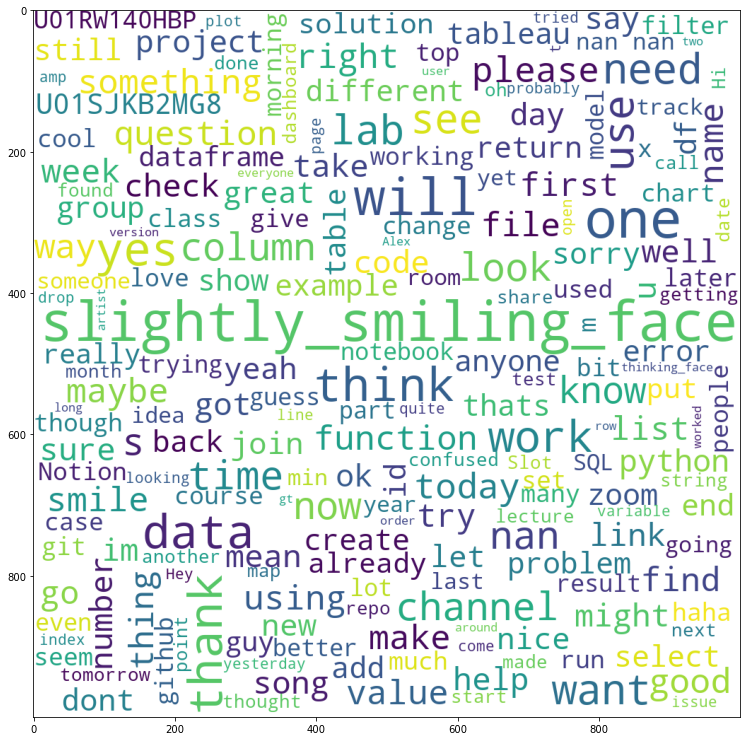

In [94]:
# apply function
make_wordcloud(df_train['text'])

### Second version

In [95]:
# import libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


wl = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

In [96]:
# utility function for preprocessing the texts
def preprocess_text(texts):
    corpus = list()
    for text in texts:
        text = re.sub(r'https?://\S+|www\.\S+','',text)    # removing website link if any present in the text 
        text = re.sub(r'[^a-zA-Z]', ' ', text)             # keeping only alphabetic characters
        text = text.lower()
        text = text.split()
        
        text = [wl.lemmatize(word) for word in text if not word in STOPWORDS]  # lemmatizing the words using wordnet lemmatizer
        text = " ".join(text)
        
        corpus.append(text)
    
    return corpus   

In [97]:
# apply function to columns
df_train['processed_text'] = preprocess_text(df_train['text'])
df_test['processed_text'] = preprocess_text(df_test['text'])

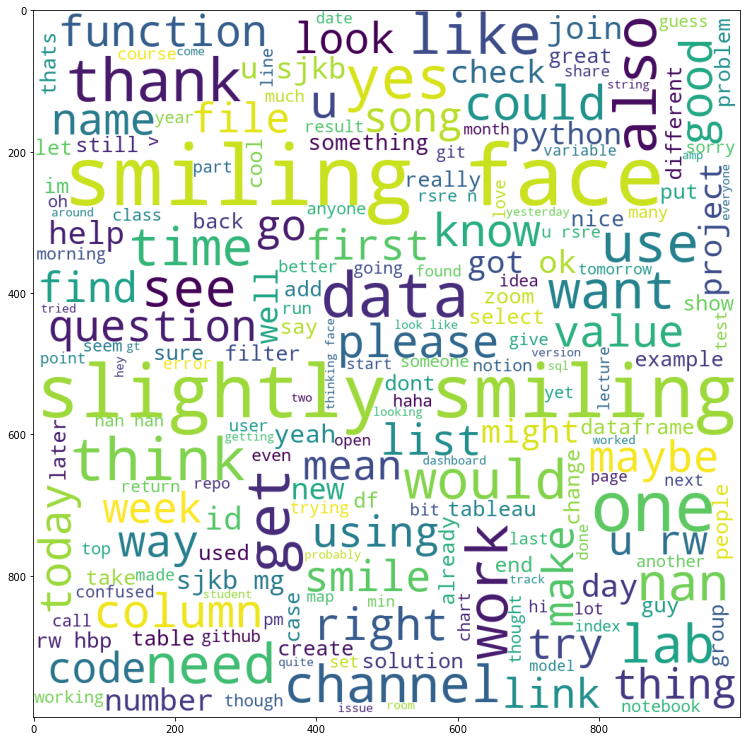

In [98]:
# apply function to df_train
make_wordcloud(df_train['processed_text'])

### Third version

In [99]:
#import libraries
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
from nltk.corpus import stopwords # stopwords
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
import unicodedata
import html

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text_list):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text_list.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # strip html
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [100]:
# apply cleaning function
df_train['prep_text'] = df_train['text'].apply(clean_text)
df_train['prep_text'].head(5)

0                              hang tell add education
1    improve score add metric achievement use synon...
2    feel like slave dumb resume word algorithm sim...
3        francisco remove fancybeautiful format upload
4                                                ah ok
Name: prep_text, dtype: object

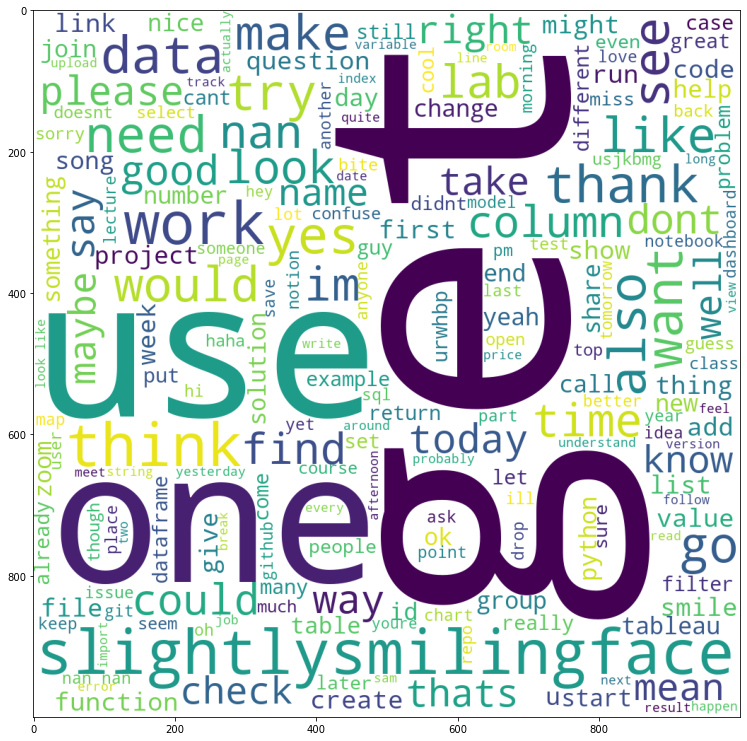

In [101]:
# apply wordcloud function
make_wordcloud(df_train['prep_text'])